# Code XGBoost

In [1]:
import numpy as np
import pandas as pd
import re
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    accuracy_score,
    roc_auc_score,
    roc_curve
)

In [4]:
df_final = pd.read_csv('GRAM-ANALYTICS/Data/Cleaned_Dataframe.csv',sep=';')
colonnes_bool = ['ANTECEDENT_FAMILIAUX', 'DIABETE', 'EXPOSITION', 'ACOUPHENES']
for col in colonnes_bool:
    df_final[col] = df_final[col].replace({'True': True, 'False': False})
    df_final[col] = df_final[col].astype('boolean')  # gère aussi les <NA>
pd.set_option('display.max_columns', None)

C:\Users\nawfe\AppData\Local\Temp\ipykernel_12400\417126397.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df_final = pd.read_csv('GRAM-ANALYTICS/Data/Cleaned_Dataframe.csv',sep=';')


On ajoute une variable qui catégorise le type de perte auditive, basé sur le test THR

In [5]:
thr_cols = [col for col in df_final.columns if col.startswith('FREQ_') and col.endswith('_THR')]
df_final['mean_thr'] = df_final[thr_cols].mean(axis=1)
def categoriser_perte(x):
    if x < 20:
        return 'Aucune'
    elif 20 <= x < 40:
        return 'Légère'
    elif 40 <= x < 60:
        return 'Moyenne'
    else:
        return 'Sévère'
df_final['PERTE'] = df_final['mean_thr'].apply(categoriser_perte)
df_final.drop(columns=['mean_thr'], inplace=True)
order_perte = ['Aucune', 'Légère', 'Moyenne', 'Sévère']
df_final['PERTE'] = pd.Categorical(
    df_final['PERTE'],
    categories=order_perte,
    ordered=True
)

---


## Création des variantes du dataset


On crée une liste de dataframes dans laquelle on va venir ajouter progressivement chaque dataframe que l'on crée

In [6]:
list_of_dfs = []
list_of_dfs.append(df_final)

On crée un dataframe avec uniquement les tests UCL et un avec uniquement les tests THR

In [7]:
df_UCL = df_final.drop(columns = df_final.columns[df_final.columns.str.endswith(('_THR'))])
df_THR = df_final.drop(columns = df_final.columns[df_final.columns.str.endswith(('_UCL'))])

list_of_dfs.append(df_UCL)
list_of_dfs.append(df_THR)
display(df_UCL.head())
display(df_THR.head())

,ID_CLIENT,ANTECEDENT_FAMILIAUX,ACOUPHENES,DIABETE,EXPOSITION,AGE,SEXE,FREQ_250_D_UCL,FREQ_250_G_UCL,FREQ_500_D_UCL,FREQ_500_G_UCL,FREQ_1000_D_UCL,FREQ_1000_G_UCL,FREQ_2000_D_UCL,FREQ_2000_G_UCL,FREQ_4000_D_UCL,FREQ_4000_G_UCL,FREQ_8000_D_UCL,FREQ_8000_G_UCL,PERTE
0,1,False,True,False,True,55.0,H,100.0,100.0,105.0,105.0,105.0,105.0,110.0,110.0,110.0,110.0,NaN,NaN,Légère
1,105,False,True,False,False,77.0,F,100.0,100.0,110.0,105.0,115.0,105.0,110.0,110.0,115.0,120.0,NaN,NaN,Moyenne
2,162,False,True,False,False,63.0,F,85.0,85.0,90.0,95.0,105.0,100.0,105.0,105.0,120.0,115.0,NaN,NaN,Sévère
3,345,False,True,False,True,65.0,F,95.0,90.0,100.0,90.0,100.0,95.0,100.0,95.0,90.0,100.0,90.0,85.0,Aucune
4,1120,False,True,False,True,0.0,F,83.0,88.0,95.0,0.0,87.0,94.0,89.0,87.0,90.0,94.0,NaN,NaN,Légère


,ID_CLIENT,ANTECEDENT_FAMILIAUX,ACOUPHENES,DIABETE,EXPOSITION,AGE,SEXE,FREQ_250_D_THR,FREQ_250_G_THR,FREQ_500_D_THR,FREQ_500_G_THR,FREQ_1000_D_THR,FREQ_1000_G_THR,FREQ_2000_D_THR,FREQ_2000_G_THR,FREQ_4000_D_THR,FREQ_4000_G_THR,FREQ_8000_D_THR,FREQ_8000_G_THR,PERTE
0,1,False,True,False,True,55.0,H,20.0,30.0,25.0,40.0,25.0,40.0,35.0,55.0,60.0,65.0,NaN,NaN,Légère
1,105,False,True,False,False,77.0,F,20.0,35.0,35.0,30.0,30.0,30.0,35.0,35.0,60.0,65.0,60.0,60.0,Moyenne
2,162,False,True,False,False,63.0,F,25.0,30.0,50.0,45.0,80.0,80.0,80.0,85.0,105.0,100.0,105.0,105.0,Sévère
3,345,False,True,False,True,65.0,F,25.0,15.0,20.0,10.0,5.0,10.0,10.0,15.0,15.0,10.0,40.0,35.0,Aucune
4,1120,False,True,False,True,0.0,F,15.0,10.0,20.0,15.0,15.0,15.0,20.0,20.0,30.0,35.0,90.0,95.0,Légère


On crée un dataframe avec uniquement les colonnes de fréquence et acouphene

In [8]:
df_FREQ = df_final[['ACOUPHENES'] + [c for c in df_final if c.startswith('FREQ')]]

list_of_dfs.append(df_FREQ)
display(df_FREQ.head())

,ACOUPHENES,FREQ_250_D_THR,FREQ_250_G_THR,FREQ_250_D_UCL,FREQ_250_G_UCL,FREQ_500_D_THR,FREQ_500_G_THR,FREQ_500_D_UCL,FREQ_500_G_UCL,FREQ_1000_D_THR,FREQ_1000_G_THR,FREQ_1000_D_UCL,FREQ_1000_G_UCL,FREQ_2000_D_THR,FREQ_2000_G_THR,FREQ_2000_D_UCL,FREQ_2000_G_UCL,FREQ_4000_D_THR,FREQ_4000_G_THR,FREQ_4000_D_UCL,FREQ_4000_G_UCL,FREQ_8000_D_THR,FREQ_8000_G_THR,FREQ_8000_D_UCL,FREQ_8000_G_UCL
0,True,20.0,30.0,100.0,100.0,25.0,40.0,105.0,105.0,25.0,40.0,105.0,105.0,35.0,55.0,110.0,110.0,60.0,65.0,110.0,110.0,NaN,NaN,NaN,NaN
1,True,20.0,35.0,100.0,100.0,35.0,30.0,110.0,105.0,30.0,30.0,115.0,105.0,35.0,35.0,110.0,110.0,60.0,65.0,115.0,120.0,60.0,60.0,NaN,NaN
2,True,25.0,30.0,85.0,85.0,50.0,45.0,90.0,95.0,80.0,80.0,105.0,100.0,80.0,85.0,105.0,105.0,105.0,100.0,120.0,115.0,105.0,105.0,NaN,NaN
3,True,25.0,15.0,95.0,90.0,20.0,10.0,100.0,90.0,5.0,10.0,100.0,95.0,10.0,15.0,100.0,95.0,15.0,10.0,90.0,100.0,40.0,35.0,90.0,85.0
4,True,15.0,10.0,83.0,88.0,20.0,15.0,95.0,0.0,15.0,15.0,87.0,94.0,20.0,20.0,89.0,87.0,30.0,35.0,90.0,94.0,90.0,95.0,NaN,NaN


On crée un dataframe avec la différence entre les colonnes UCL et THR

In [9]:
df_UCL_THR = df_final.copy()
pattern = r'^FREQ_(\d+)_([DG])_(UCL|THR)$'
freq_sides = {
    (m.group(1), m.group(2))
    for col in df_UCL_THR.columns
    if (m := re.match(pattern, col))
}
for hz, side in freq_sides:
    col_ucl = f'FREQ_{hz}_{side}_UCL'
    col_thr = f'FREQ_{hz}_{side}_THR'
    newcol  = f'FREQ_{hz}_{side}'
    df_UCL_THR[newcol] = df_UCL_THR[col_ucl] - df_UCL_THR[col_thr]

df_UCL_THR = df_UCL_THR.drop(columns=df_UCL_THR.columns[df_UCL_THR.columns.str.endswith(('_UCL', '_THR'))])

list_of_dfs.append(df_UCL_THR)
display(df_UCL_THR.head())

,ID_CLIENT,ANTECEDENT_FAMILIAUX,ACOUPHENES,DIABETE,EXPOSITION,AGE,SEXE,PERTE,FREQ_500_D,FREQ_500_G,FREQ_2000_D,FREQ_8000_G,FREQ_8000_D,FREQ_1000_D,FREQ_4000_D,FREQ_1000_G,FREQ_4000_G,FREQ_250_G,FREQ_250_D,FREQ_2000_G
0,1,False,True,False,True,55.0,H,Légère,80.0,65.0,75.0,NaN,NaN,80.0,50.0,65.0,45.0,70.0,80.0,55.0
1,105,False,True,False,False,77.0,F,Moyenne,75.0,75.0,75.0,NaN,NaN,85.0,55.0,75.0,55.0,65.0,80.0,75.0
2,162,False,True,False,False,63.0,F,Sévère,40.0,50.0,25.0,NaN,NaN,25.0,15.0,20.0,15.0,55.0,60.0,20.0
3,345,False,True,False,True,65.0,F,Aucune,80.0,80.0,90.0,50.0,50.0,95.0,75.0,85.0,90.0,75.0,70.0,80.0
4,1120,False,True,False,True,0.0,F,Légère,75.0,-15.0,69.0,NaN,NaN,72.0,60.0,79.0,59.0,78.0,68.0,67.0


On crée un dataframe avec les fréquences uniquement entre 500 et 8000 hz

In [10]:
df_mid_FREQ = df_final.drop(columns = df_final.columns[df_final.columns.str.startswith(('FREQ_250', 'FREQ_8000'))])

list_of_dfs.append(df_mid_FREQ)
display(df_mid_FREQ.head())

,ID_CLIENT,ANTECEDENT_FAMILIAUX,ACOUPHENES,DIABETE,EXPOSITION,AGE,SEXE,FREQ_500_D_THR,FREQ_500_G_THR,FREQ_500_D_UCL,FREQ_500_G_UCL,FREQ_1000_D_THR,FREQ_1000_G_THR,FREQ_1000_D_UCL,FREQ_1000_G_UCL,FREQ_2000_D_THR,FREQ_2000_G_THR,FREQ_2000_D_UCL,FREQ_2000_G_UCL,FREQ_4000_D_THR,FREQ_4000_G_THR,FREQ_4000_D_UCL,FREQ_4000_G_UCL,PERTE
0,1,False,True,False,True,55.0,H,25.0,40.0,105.0,105.0,25.0,40.0,105.0,105.0,35.0,55.0,110.0,110.0,60.0,65.0,110.0,110.0,Légère
1,105,False,True,False,False,77.0,F,35.0,30.0,110.0,105.0,30.0,30.0,115.0,105.0,35.0,35.0,110.0,110.0,60.0,65.0,115.0,120.0,Moyenne
2,162,False,True,False,False,63.0,F,50.0,45.0,90.0,95.0,80.0,80.0,105.0,100.0,80.0,85.0,105.0,105.0,105.0,100.0,120.0,115.0,Sévère
3,345,False,True,False,True,65.0,F,20.0,10.0,100.0,90.0,5.0,10.0,100.0,95.0,10.0,15.0,100.0,95.0,15.0,10.0,90.0,100.0,Aucune
4,1120,False,True,False,True,0.0,F,20.0,15.0,95.0,0.0,15.0,15.0,87.0,94.0,20.0,20.0,89.0,87.0,30.0,35.0,90.0,94.0,Légère


On crée un dataframpe avec les coefficients directeurs pour chaque freq et chaque test

In [11]:
# 1) copier le df de base
df_coeff = df_final.copy()

# 2) extraire toutes les fréquences existantes dans les colonnes FREQ_XXX_... 
pattern = r'^FREQ_(\d+)_([DG])_(UCL|THR)$'
# Set de fréquences (ex. {250, 500, 1000, …})
freqs = sorted({
    int(m.group(1))
    for col in df_coeff.columns
    if (m := re.match(pattern, col))
})
# transformer en chaines triées : ['250','500','1000',…]
freqs = list(map(str, freqs))

# 3) boucle pour créer les COEFF
coeffs = {}
for test in ['THR','UCL']:
    for side in ['D','G']:
        for i in range(len(freqs)-1):
            low, high = freqs[i], freqs[i+1]
            col_low  = f'FREQ_{low}_{side}_{test}'
            col_high = f'FREQ_{high}_{side}_{test}'
            newcol   = f'COEFF_{low}_{side}_{test}'
            coeffs[newcol] = df_coeff[col_high] - df_coeff[col_low]

# 4) nouveau DataFrame à partir du dict (index conservé)
df_coeff = pd.DataFrame(coeffs, index=df_coeff.index)
df_coeff = pd.concat([df_final[['ID_CLIENT', 'ANTECEDENT_FAMILIAUX', 'ACOUPHENES', 'DIABETE', 'EXPOSITION', 'AGE', 'SEXE']], df_coeff], axis=1)

list_of_dfs.append(df_coeff)
display(df_coeff.head())

,ID_CLIENT,ANTECEDENT_FAMILIAUX,ACOUPHENES,DIABETE,EXPOSITION,AGE,SEXE,COEFF_250_D_THR,COEFF_500_D_THR,COEFF_1000_D_THR,COEFF_2000_D_THR,COEFF_4000_D_THR,COEFF_250_G_THR,COEFF_500_G_THR,COEFF_1000_G_THR,COEFF_2000_G_THR,COEFF_4000_G_THR,COEFF_250_D_UCL,COEFF_500_D_UCL,COEFF_1000_D_UCL,COEFF_2000_D_UCL,COEFF_4000_D_UCL,COEFF_250_G_UCL,COEFF_500_G_UCL,COEFF_1000_G_UCL,COEFF_2000_G_UCL,COEFF_4000_G_UCL
0,1,False,True,False,True,55.0,H,5.0,0.0,10.0,25.0,NaN,10.0,0.0,15.0,10.0,NaN,5.0,0.0,5.0,0.0,NaN,5.0,0.0,5.0,0.0,NaN
1,105,False,True,False,False,77.0,F,15.0,-5.0,5.0,25.0,0.0,-5.0,0.0,5.0,30.0,-5.0,10.0,5.0,-5.0,5.0,NaN,5.0,0.0,5.0,10.0,NaN
2,162,False,True,False,False,63.0,F,25.0,30.0,0.0,25.0,0.0,15.0,35.0,5.0,15.0,5.0,5.0,15.0,0.0,15.0,NaN,10.0,5.0,5.0,10.0,NaN
3,345,False,True,False,True,65.0,F,-5.0,-15.0,5.0,5.0,25.0,-5.0,0.0,5.0,-5.0,25.0,5.0,0.0,0.0,-10.0,0.0,0.0,5.0,0.0,5.0,-15.0
4,1120,False,True,False,True,0.0,F,5.0,-5.0,5.0,10.0,60.0,5.0,0.0,5.0,15.0,60.0,12.0,-8.0,2.0,1.0,NaN,-88.0,94.0,-7.0,7.0,NaN


---

## Prédictions de l'acouphène

XGBoost

In [16]:
import warnings
import logging
import io
from contextlib import redirect_stdout, redirect_stderr

warnings.filterwarnings("ignore")
logging.getLogger().setLevel(logging.ERROR)

import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_curve, auc
)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE

def train_xgboost(
    df: pd.DataFrame,
    n_splits: int = 5,
    top_k: int = 3
) -> None:
    """
    Entraîne un XGBoost avec validation croisée + SMOTE, affiche :
     - scores CV, matrice de confusion, ROC, importance des variables
    """
    df = df.copy()

    # Cible binaire
    df['target'] = df['ACOUPHENES'].astype(str).str.lower().map({'oui': 1, 'non': 0})
    y = df['target']
    X = df.drop(columns=['ID_CLIENT', 'ACOUPHENES', 'target'], errors='ignore')

    # Séparation colonnes
    num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
    cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

    # Imputation + encodage
    X[num_cols] = SimpleImputer(strategy='median').fit_transform(X[num_cols])
    for col in cat_cols:
        X[col] = X[col].fillna('missing').astype(str)
        X[col] = LabelEncoder().fit_transform(X[col])

    # Validation croisée + SMOTE
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    y_true, y_pred, y_proba = [], [], []
    importances = np.zeros(X.shape[1])

    for train_idx, test_idx in skf.split(X, y):
        X_train, X_val = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[test_idx]

        X_train_res, y_train_res = SMOTE(random_state=42).fit_resample(X_train, y_train)

        model = xgb.XGBClassifier(
            n_estimators=300,
            max_depth=6,
            learning_rate=0.1,
            subsample=0.8,
            colsample_bytree=0.8,
            scale_pos_weight=1,
            objective='binary:logistic',
            eval_metric='logloss',
            use_label_encoder=False,
            random_state=42,
            n_jobs=-1
        )

        with redirect_stdout(io.StringIO()), redirect_stderr(io.StringIO()):
            model.fit(X_train_res, y_train_res)

        proba = model.predict_proba(X_val)[:, 1]
        pred = model.predict(X_val)

        y_true.extend(y_val)
        y_pred.extend(pred)
        y_proba.extend(proba)
        importances += model.feature_importances_

    importances /= n_splits
    fi = pd.DataFrame({'feature': X.columns, 'importance': importances})
    fi.sort_values('importance', ascending=False, inplace=True)

    # --- Résultats ---
    print(f"=== XGBoost CV ({n_splits} plis) ===")
    print("Accuracy :", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall   :", recall_score(y_true, y_pred))
    print("F1-score :", f1_score(y_true, y_pred))
    print("\nClassification Report:\n",
          classification_report(y_true, y_pred, digits=4))

    # Matrice de confusion
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Non', 'Oui'], yticklabels=['Non', 'Oui'])
    plt.title("Matrice de confusion (XGBoost CV)")
    plt.show()

    # ROC
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f"AUC = {auc(fpr, tpr):.4f}")
    plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
    plt.title("ROC Curve (XGBoost CV)")
    plt.legend()
    plt.show()

    # Importances
    plt.figure(figsize=(8, max(4, 0.3 * top_k)))
    sns.barplot(x='importance', y='feature', data=fi.head(top_k))
    plt.title(f"Top {top_k} variables (importance moyenne)")
    plt.tight_layout()
    plt.show()


=== XGBoost CV (5 plis) ===
Accuracy : 0.5887595343235649
Precision: 0.571375951542932
Recall   : 0.4797924255962609
F1-score : 0.5215945602630202

Classification Report:
               precision    recall  f1-score   support

           0     0.6000    0.6843    0.6394     33177
           1     0.5714    0.4798    0.5216     29098

    accuracy                         0.5888     62275
   macro avg     0.5857    0.5821    0.5805     62275
weighted avg     0.5866    0.5888    0.5843     62275



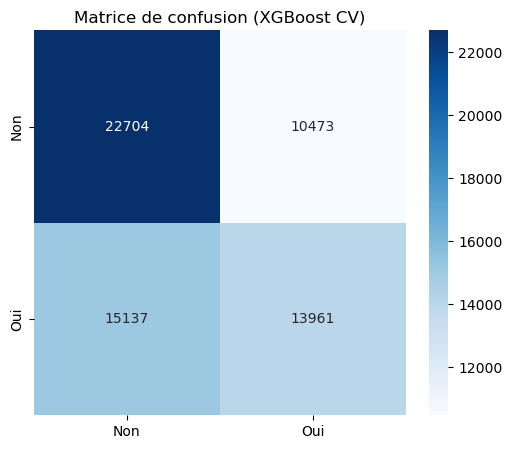

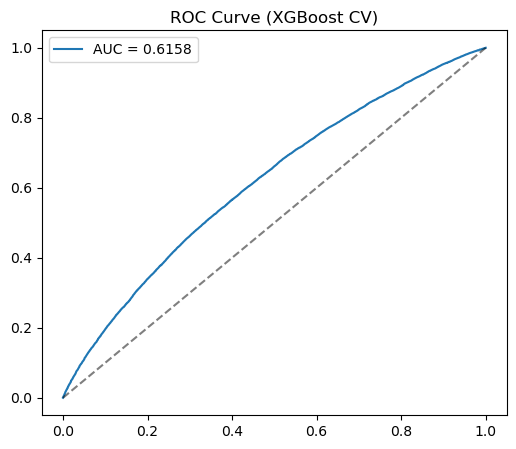

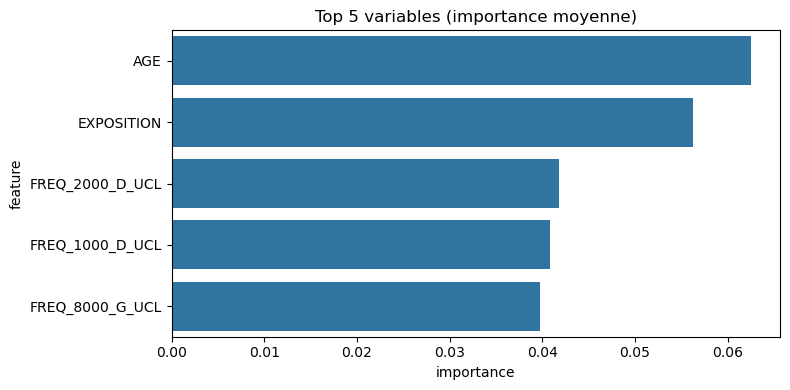

In [17]:
df = pd.read_csv("df_final.csv", sep=';')
train_xgboost(df, n_splits=5, top_k=5)
